In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline
import imageio
from IPython.display import clear_output

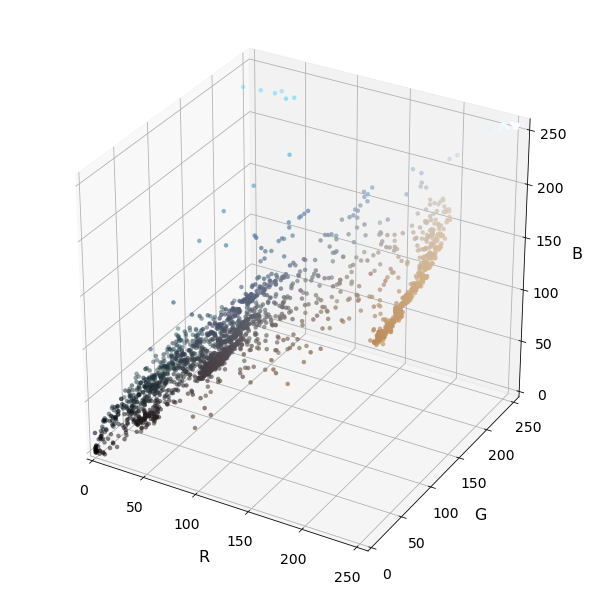

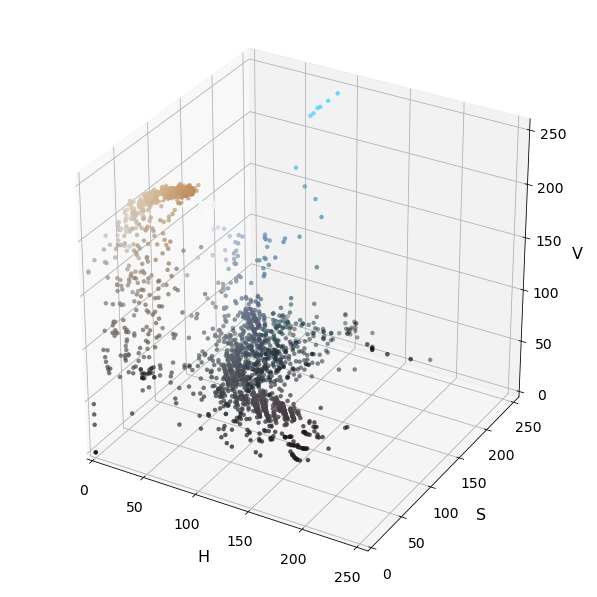

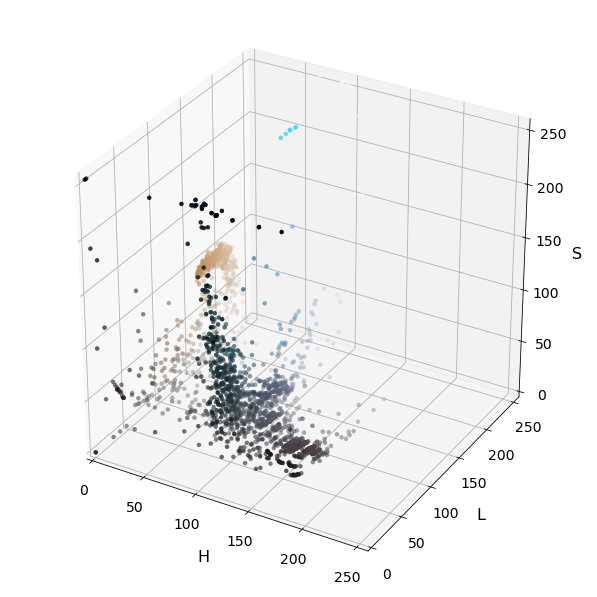

In [2]:
from mpl_toolkits.mplot3d import Axes3D
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("test.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

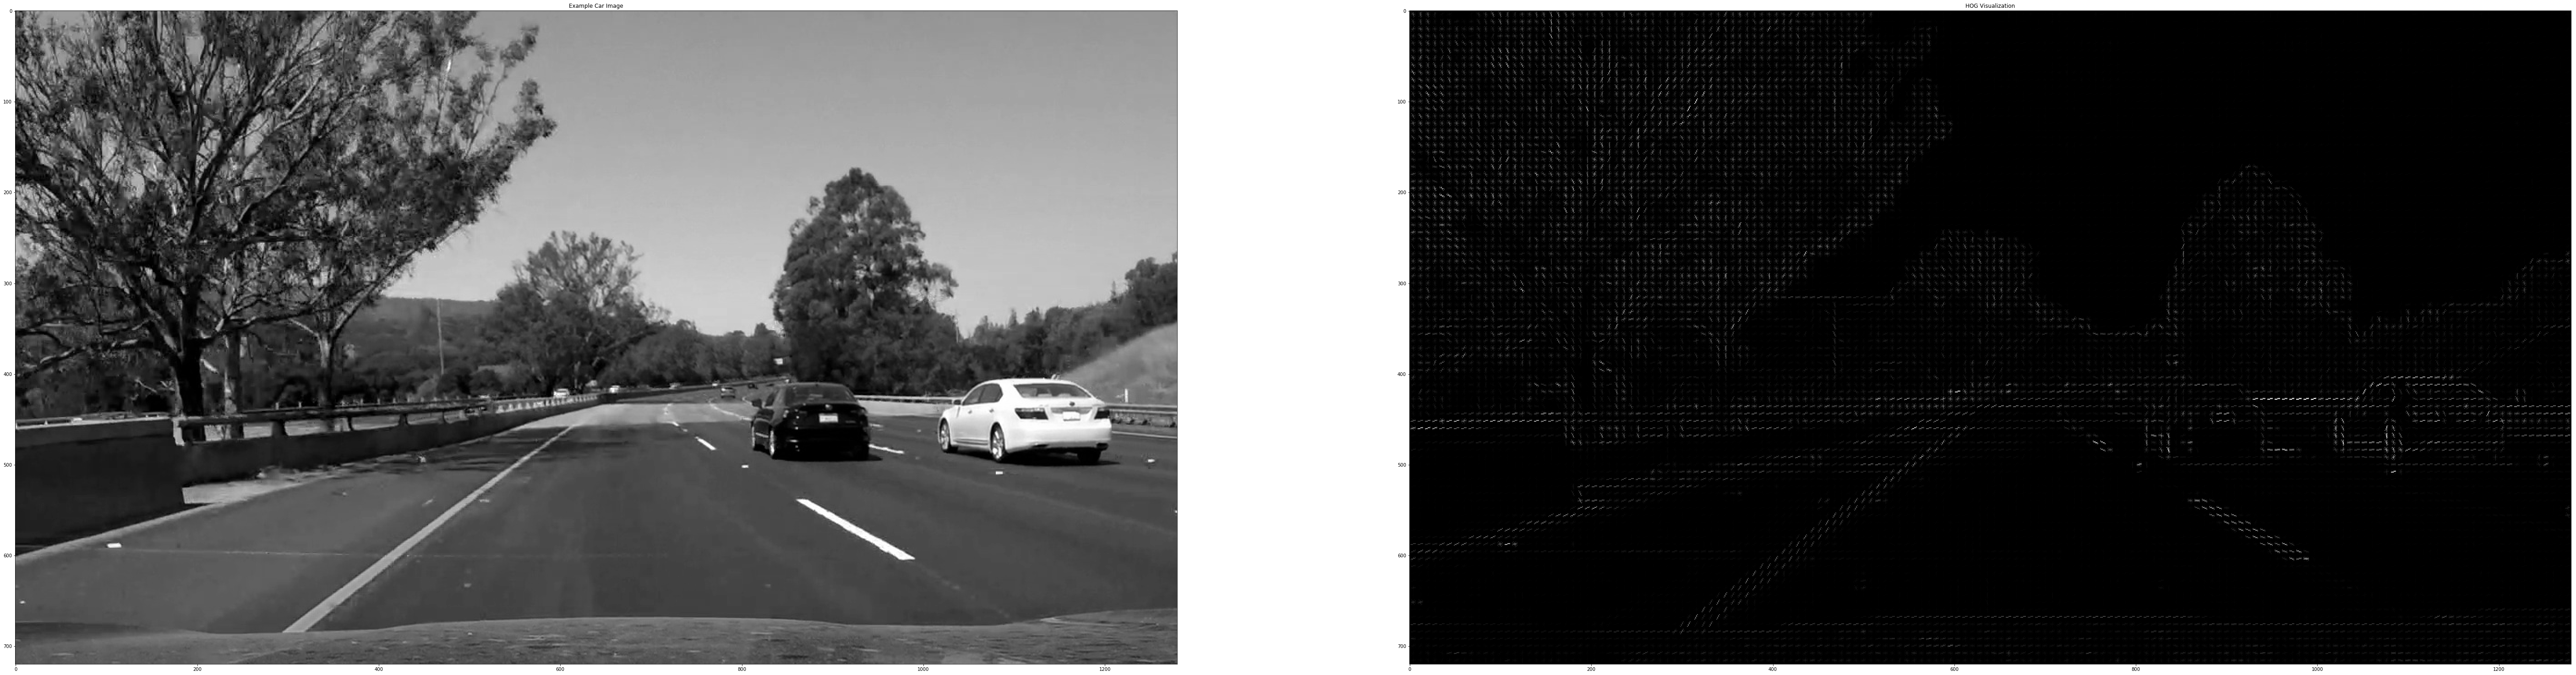

In [3]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
norm=np.zeros(gray.shape)
norm = cv2.normalize(gray,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
features, hog_image = hog(norm, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

# Plot the examples
fig = plt.figure()
plt.figure(figsize=(100,50))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [4]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def hog_tweak(car_img_f,notcar_img_f,pix_per_cell = 8,cell_per_block = 2,orient = 9):
    raw = cv2.imread(car_img_f)
    # normalize image
    norm=np.zeros(raw.shape)
    norm = cv2.normalize(raw,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    norm = cv2.cvtColor(norm,cv2.COLOR_BGR2HLS)
    img = norm[:,:,1]
    features, hog_image_car = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

    raw = cv2.imread(notcar_img_f)
    # normalize image
    norm=np.zeros(raw.shape)
    norm = cv2.normalize(raw,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    norm = cv2.cvtColor(norm,cv2.COLOR_BGR2HLS)
    img = norm[:,:,1]
    features, hog_image_notcar = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

    # Plot the examples
    print('pix_per_cell:',pix_per_cell,'cell_per_block:',cell_per_block,'orient:',orient)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(hog_image_car, cmap='gray')
    plt.title('Car HOG Visualization')
    plt.subplot(122)
    plt.imshow(hog_image_notcar, cmap='gray')
    plt.title('Not car HOG Visualization')

<function __main__.hog_tweak>

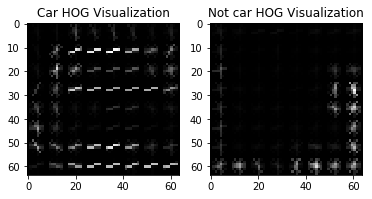

In [5]:
interact(hog_tweak,car_img_f='./trainig_image/vehicles/1.png',notcar_img_f='./trainig_image/non-vehicles/extra1.png',pix_per_cell = (1,24),cell_per_block = (1,10),orient = (6,25))

In [6]:
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255
        # normalize image
        norm=np.zeros(image.shape)
        norm = cv2.normalize(image,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8UC3)
        #print(norm.dtype)
             # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(norm)      
            
   
        img_features=[]
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                #hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

CarSample 8792
NonCarSample 8968
Extract feature of cars
Extract feature of not cars
Classify images


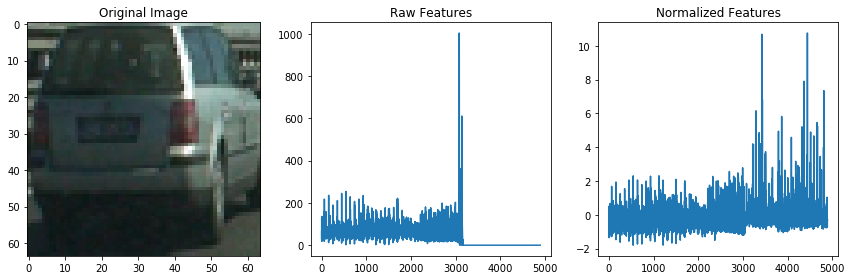

In [8]:

cars = []
notcars = []
car_images = glob.glob('./trainig_image/vehicles/*.png')
for image in car_images:
    cars.append(image)
car_images = glob.glob('./trainig_image/vehicles/GTI_Far/*.png')
for image in car_images:
    cars.append(image)
car_images = glob.glob('./trainig_image/vehicles/GTI_Left/*.png')
for image in car_images:
    cars.append(image)
car_images = glob.glob('./trainig_image/vehicles/GTI_MiddleClose/*.png')
for image in car_images:
    cars.append(image)
car_images = glob.glob('./trainig_image/vehicles/GTI_Right/*.png')
for image in car_images:
    cars.append(image)
notcar_images = glob.glob('./trainig_image/non-vehicles/*.png')
for image in notcar_images:
    notcars.append(image)
print('CarSample',len(cars))
print('NonCarSample',len(notcars))
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32
cspase = 'HSV'
print('Extract feature of cars')
car_features = extract_features(cars, cspace=cspase, spatial_size=(spatial, spatial),
                                orient=9,pix_per_cell=8,cell_per_block=8,hog_channel='ALL',hog_feat=True,
                                hist_bins=histbin, hist_range=(0, 256))
print('Extract feature of not cars')
notcar_features = extract_features(notcars, cspace=cspase, spatial_size=(spatial, spatial),
                                   orient=9,pix_per_cell=8,cell_per_block=8,hog_channel='ALL',hog_feat=True,
                                   hist_bins=histbin, hist_range=(0, 256)) 

if len(car_features) > 0:
    print('Classify images')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [9]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
import time
from sklearn.grid_search import GridSearchCV

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#loss : string, ‘hinge’ or ‘squared_hinge’
parameters = {'loss':('hinge', 'squared_hinge'), 'C':[1.0, 10,0.1]} 

clf = GridSearchCV(svc, parameters) 
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

/home/saka1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/saka1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4896
13.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
0.0015 Seconds to predict 10 labels with SVC
{'C': 1.0, 'loss': 'hinge'}
0.992117117117


In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=4, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    # normalize image
    norm=np.zeros(img.shape)
    norm = cv2.normalize(img,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8UC3)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(norm, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(norm)      

    #normalize image
    norm=np.zeros(feature_image.shape)
    feature_image = cv2.normalize(feature_image,norm,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8UC3)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=8, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0] *int(1+1*ys/ny_windows)
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1] *int(1+1*ys/ny_windows)
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


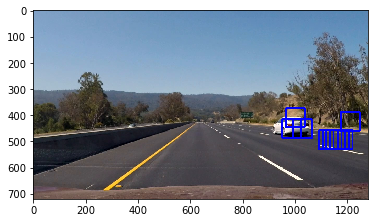

In [12]:
image = mpimg.imread('./sample.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

window_size=[72,96]
windows=[]
for w in window_size:
    windows.extend(slide_window(image, y_start_stop=[int(image.shape[0]*0.5),int(image.shape[0]*0.75)],
                        xy_window=(w, w), xy_overlap=(0.8, 0.8)))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=cspase,pix_per_cell=8, cell_per_block=8 )                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [13]:
def add_heat(heatmap, bbox_list,weight=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += weight

    # Return updated heatmap
    return heatmap

In [14]:
def apply_threshold(heatmap, threshold=3):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [16]:
from scipy.ndimage.measurements import label
def pipeline(image,heatmap=None):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    window_size=[128,144]
    windows=[]
    for w in window_size:
        windows.extend(slide_window(image, y_start_stop=[int(image.shape[0]*0.5),int(image.shape[0]*0.75)],
                            xy_window=(w, w), xy_overlap=(0.9, 0.9)))

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space='HSV',pix_per_cell=8, cell_per_block=8)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    if heatmap is None:
        heatmap = np.zeros([image.shape[0],image.shape[1]])
    heatmap=heatmap*0.8
    heatmap = add_heat(heatmap,hot_windows,weight=1)
    # Erosion heatmap
    #kernel = np.ones((32,32),np.uint8)
    #heatmap = cv2.morphologyEx(heatmap, cv2.MORPH_OPEN, kernel)
    heatmap = apply_threshold(heatmap,threshold=3)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(image, labels)
    
    print(labels[1], 'cars found')
    return draw_image,heatmap,window_img

1 cars found


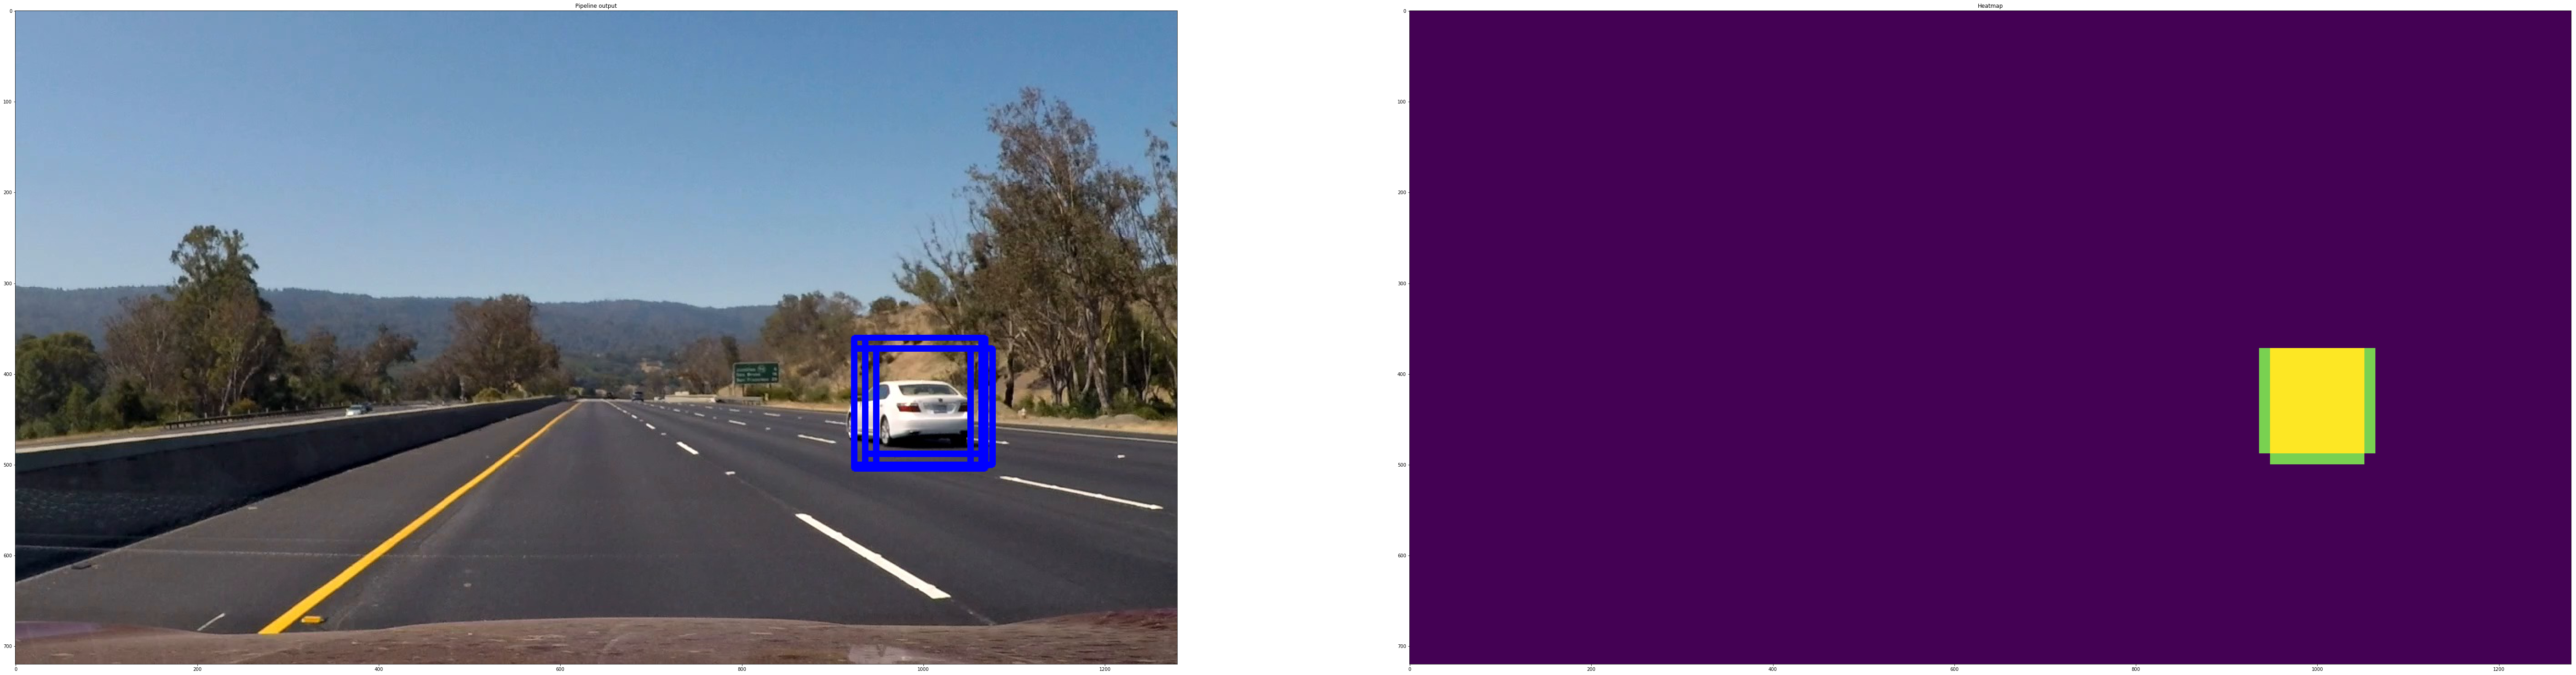

In [17]:
image = mpimg.imread('./sample.jpg')
result,heatmap,window_img=pipeline(image)
fig = plt.figure()
plt.figure(figsize=(100,50))
plt.subplot(121)
plt.imshow(window_img)
plt.title('Pipeline output')
plt.subplot(122)
plt.imshow(heatmap)
plt.title('Heatmap')

In [18]:
from IPython.display import clear_output
filename = './test_video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
l = vid.get_length()
fps = vid.get_meta_data()['fps']
ResultWriter = imageio.get_writer('./test_result.mp4', fps=fps)
img = vid.get_data(0)
heatmap = np.zeros([img.shape[0],img.shape[1]])
for frame in range(l):
    clear_output()
    print('frame:',frame+1,'/',l)
    img = vid.get_data(frame)
    output,heatmap,window = pipeline(img,heatmap)
    ResultWriter.append_data(output)
ResultWriter.close()

frame: 38 / 38
2 cars found


In [19]:
filename = './project_video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
l = vid.get_length()
fps = vid.get_meta_data()['fps']
ResultWriter = imageio.get_writer('./project_result.mp4', fps=fps)
img = vid.get_data(0)
heatmap = np.zeros([img.shape[0],img.shape[1]])
for frame in range(l):
    clear_output()
    print('frame:',frame+1,'/',l)
    img = vid.get_data(frame)
    output,heatmap,window = pipeline(img,heatmap)
    ResultWriter.append_data(output)
ResultWriter.close()

frame: 1260 / 1260
2 cars found


In [20]:
def searchFeature(out_path,cars,notcars,window_size,spatial_size=(spatial, spatial),
                        color_space='RGB', spatial=32,
                        hist_bin=32, orient=9, 
                        pix_per_cell=8, cell_per_block=8, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    print('CarSample:',len(cars))
    print('NonCarSample:',len(notcars))
    car_features = extract_features(cars, cspace=cspase, spatial_size=(spatial, spatial),orient=orient,hog_channel=hog_channel,
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hist_bins=hist_bin, hist_range=(0, 256),
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, cspace=cspase, spatial_size=(spatial, spatial),orient=orient,hog_channel=hog_channel,
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hist_bins=hist_bin, hist_range=(0, 256),
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    s = svc.score(X_test, y_test)
    print('Test Accuracy of SVC = ', round(s, 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    #loss : string, ‘hinge’ or ‘squared_hinge’
    #parameters = {'loss':('hinge', 'squared_hinge'), 'C':[1.0, 10,0.1]} 

    #clf = GridSearchCV(svc, parameters) 
    #clf.fit(X_train, y_train)

    test_images = glob.glob('./test_images/*.jpg')
    total_detected = 0
    for test_image in test_images:
        image = mpimg.imread(test_image)
        draw_image = np.copy(image)

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        #image = image.astype(np.float32)/255
        windows=[]
        for w in window_size:
            print(w)
            windows.extend(slide_window(image, y_start_stop=[int(image.shape[0]*0.5),int(image.shape[0]*0.75)],
                                xy_window=(w, w), xy_overlap=(0.8, 0.8)))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspase ,orient=orient, hist_bins=hist_bin,hog_channel=hog_channel,
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
        window_img = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)
        cv2.imwrite(out_path+'out_'+os.path.basename(test_image),window_img)
        print('Number of hot_windows:',len(hot_windows))
        total_detected = total_detected+len(hot_windows)
        #plt.imshow(window_img)
        
    return total_detected,s

In [21]:
Lorient = [5,9]
Lhog_channel = [0,1,2,'ALL']
Lcolor_space=['RGB','HSV','LUV','HLS','YCrCb']


In [22]:
import os
import heapq
n = 0
min_detect=10000000
min_num=0
detect=[]
max_score=0.0
score_num=0
score=[]
for color_space in Lcolor_space:
    print(n,':',color_space)
    out_path = './test_out/'+str(n)+'/'
    d,s = searchFeature(out_path,cars,notcars,[72],color_space=color_space)
    heapq.heappush(detect,(d,n))
    if min_detect > d:
        min_detect = d
        min_num= n
    heapq.heappush(score, (s,n))
    if max_score < s:
        max_score = s
        score_num= n
    n = n+1

0 : RGB
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4896
12.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.]
0.0062 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 23
72
Number of hot_windows: 35
72
Number of hot_windows: 18
72
Number of hot_windows: 5
72
Number of hot_windows: 7
72
Number of hot_windows: 5
1 : HSV
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4896
12.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00122 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 30
72
Number of hot_windows: 38
72
Number of hot_windows: 16
72
Number of hot_windows: 6
72
Number 

In [ ]:
min_detect=10000000
min_num=0
detect=[]
max_score=0.0
score_num=0
score=[]
for hog_channel in Lhog_channel:
    print(n,'channel of hog:',hog_channel)
    out_path = './test_out/'+str(n)+'/'
    d,s = searchFeature(out_path,cars,notcars,[72],hog_channel=hog_channel,
                        color_space='HLS')
    heapq.heappush(detect,(d,n))
    if min_detect > d:
        min_detect = d
        min_num= n
    heapq.heappush(score, (s,n))
    if max_score < s:
        max_score = s
        score_num= n
    n = n+1

5 channel of hog: 0
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3744
12.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9662
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
0.00134 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 45
72
Number of hot_windows: 68
72
Number of hot_windows: 45
72
Number of hot_windows: 7
72
Number of hot_windows: 19
72
Number of hot_windows: 10
6 channel of hog: 1
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3744
11.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9688
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00122 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 44
72
Number of hot_windows: 60
72
Number of hot_windows: 40
72
Number 

In [ ]:
Lspatial_feat=[True,False]
Lhist_feat=[True,False]
min_detect=10000000
min_num=0
detect=[]
max_score=0.0
score_num=0
score=[]
for spatial_feat in Lspatial_feat:
    for hist_feat in Lhist_feat:
        print(n,'spatial_feat:',spatial_feat,'hist_feat',hist_feat)
        out_path = './test_out/'+str(n)+'/'
        d,s = searchFeature(out_path,cars,notcars,[72],hog_channel='ALL',
                            spatial_feat=spatial_feat,hist_feat=hist_feat,color_space='HLS')
        heapq.heappush(detect,(d,n))
        if min_detect > d:
            min_detect = d
            min_num= n
        heapq.heappush(score, (s,n))
        if max_score < s:
            max_score = s
            score_num= n
        n = n+1

9 spatial_feat: True hist_feat True
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4896
12.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00122 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 28
72
Number of hot_windows: 33
72
Number of hot_windows: 14
72
Number of hot_windows: 5
72
Number of hot_windows: 7
72
Number of hot_windows: 4
10 spatial_feat: True hist_feat False
CarSample: 8792
NonCarSample: 8968
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4800
13.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.00125 Seconds to predict 10 labels with SVC
72
Number of hot_windows: 31
72
Number of hot_windows: 34
72
Numb

In [ ]:
# Read a color image./trainig_image/vehicles/1.png',notcar_img_f='./trainig_image/non-vehicles/extra1.png'
car_img = cv2.imread("./trainig_image/vehicles/1.png")
notcar_img = cv2.imread("./trainig_image/non-vehicles/extra1.png")
# Plot the examples
fig = plt.figure()
plt.figure(figsize=(100,50))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car')
plt.subplot(122)
plt.imshow(notcar_img)
plt.title('Not-Car')